## **Random Forest from Scratch**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

The *generate_data* function creates synthetic data with various noise patterns and with non linearly separable classes. Also, there's significant overlap between classes. We also built *train_test_split* to divide data for model training/testing and *standardize_data* for data standardization

In [5]:
def generate_data(n_samples=1000, n_features=4, n_classes=3, n_clusters_per_class=2, 
                 noise_level=0.8, overlap_factor=0.5):
    """Generate challenging synthetic multi-class classification data."""
    n_samples_per_class = n_samples // n_classes
    n_samples_per_cluster = n_samples_per_class // n_clusters_per_class
    
    X_list = []
    y_list = []
    
    def generate_positive_semidefinite_matrix(n):
        A = np.random.uniform(-0.5, 0.5, (n, n))
        return np.dot(A, A.T) + np.eye(n)
    
    for class_idx in range(n_classes):
        for cluster_idx in range(n_clusters_per_class):
            cluster_center = np.random.uniform(-5, 5, n_features)
            covariance = generate_positive_semidefinite_matrix(n_features)
            covariance *= np.random.uniform(0.5, 2.0)
            
            if cluster_idx > 0:
                cluster_center += np.random.normal(0, overlap_factor, n_features)
            
            cluster_samples = np.random.multivariate_normal(
                cluster_center,
                covariance,
                n_samples_per_cluster
            )
            X_list.append(cluster_samples)
            y_list.append(np.full(n_samples_per_cluster, class_idx))
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    X += np.random.normal(0, noise_level, X.shape)
    
    n_outliers = int(0.05 * len(X))
    outlier_idx = np.random.choice(len(X), n_outliers, replace=False)
    X[outlier_idx] += np.random.normal(0, noise_level * 3, (n_outliers, n_features))
    
    shuffle_idx = np.random.permutation(len(X))
    return X[shuffle_idx], y[shuffle_idx]

def train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Split arrays into random train and test subsets.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Features array
    y : numpy.ndarray
        Target array
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int or None
        Controls the shuffling applied to the data
        
    Returns:
    --------
    X_train, X_test, y_train, y_test
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(X)
    n_test = int(n_samples * test_size)
    
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

def standardize_data(X_train, X_test):
    """
    Standardize features by removing the mean and scaling to unit variance.
    
    Parameters:
    -----------
    X_train : numpy.ndarray
        Training features array
    X_test : numpy.ndarray
        Test features array
        
    Returns:
    --------
    X_train_scaled, X_test_scaled, mean, std
    """
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    std = np.where(std == 0, 1, std)
    
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    
    return X_train_scaled, X_test_scaled, mean, std

#### **Main Components**

A *DecisionTreeClassifier* class that implements a single decision tree

A *RandomForestClassifier* class that manages multiple trees and aggregates their predictions


##### Decision Tree Key Features

- Uses Gini impurity for splitting criteria
- Supports multi-class classification
- Includes hyperparameters for max_depth and min_samples_split
- Stores class probabilities at leaf nodes
- Uses recursive tree building with best split selection


##### Random Forest Core Process

- Creates multiple decision trees using:
  * Bootstrap sampling (random sampling with replacement)
  * Feature subsampling at each split (controlled by max_features)
- Supports different feature selection strategies:
  * 'sqrt': Square root of total features
  * 'log2': Log base 2 of total features
  * Float: Fraction of total features
  * Integer: Specific number of features


##### Prediction Process

- Each tree makes its own prediction
- Final prediction is an average of all trees' probability predictions
- Class with highest average probability is selected as final prediction

In [8]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.n_classes = None
        
    def _calculate_gini(self, y):
        """Calculate Gini impurity for multi-class"""
        if len(y) == 0:
            return 0
        
        n_samples = len(y)
        gini = 1.0
        
        for c in range(self.n_classes):
            p = np.sum(y == c) / n_samples
            gini -= p ** 2
            
        return gini
    
    def _split_data(self, X, y, feature_idx, threshold):
        """Split data based on feature and threshold"""
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        return (X[left_mask], X[right_mask], 
                y[left_mask], y[right_mask])
    
    def _find_best_split(self, X, y):
        """Find the best split that minimizes Gini impurity"""
        n_samples, n_features = X.shape
        best_gini = float('inf')
        best_split = None
        
        if n_samples < self.min_samples_split:
            return None
            
        current_gini = self._calculate_gini(y)
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split_data(
                    X, y, feature_idx, threshold)
                
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                    
                gini_left = self._calculate_gini(y_left)
                gini_right = self._calculate_gini(y_right)
                
                gini = (len(y_left) * gini_left + len(y_right) * gini_right) / n_samples
                
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_idx, threshold)
        
        if best_gini == current_gini:
            return None
            
        return best_split
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        n_samples = len(y)
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            class_probs = np.zeros(self.n_classes)
            for c in range(self.n_classes):
                class_probs[c] = np.sum(y == c) / n_samples
            return {'type': 'leaf', 'probabilities': class_probs}
        
        best_split = self._find_best_split(X, y)
        
        if best_split is None:
            class_probs = np.zeros(self.n_classes)
            for c in range(self.n_classes):
                class_probs[c] = np.sum(y == c) / n_samples
            return {'type': 'leaf', 'probabilities': class_probs}
            
        feature_idx, threshold = best_split
        X_left, X_right, y_left, y_right = self._split_data(
            X, y, feature_idx, threshold)
        
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return {
            'type': 'node',
            'feature_idx': feature_idx,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }
    
    def fit(self, X, y):
        """Train the decision tree"""
        self.n_classes = len(np.unique(y))
        self.tree = self._build_tree(X, y)
        return self
    
    def _predict_single_proba(self, x, tree):
        """Predict class probabilities for single sample"""
        if tree['type'] == 'leaf':
            return tree['probabilities']
            
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict_single_proba(x, tree['left'])
        return self._predict_single_proba(x, tree['right'])
    
    def predict_proba(self, X):
        """Predict class probabilities for multiple samples"""
        return np.array([self._predict_single_proba(x, self.tree) for x in X])
    
    def predict(self, X):
        """Predict class labels for multiple samples"""
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, 
                 min_samples_split=2, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.n_classes = None
        
    def _bootstrap_sample(self, X, y):
        """Create a bootstrap sample"""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_max_features(self, n_features):
        """Get number of features to consider at each split"""
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                return max(1, int(np.sqrt(n_features)))
            elif self.max_features == 'log2':
                return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        elif isinstance(self.max_features, int):
            return min(self.max_features, n_features)
        return n_features
    
    def fit(self, X, y):
        """Train the random forest"""
        self.trees = []
        self.n_classes = len(np.unique(y))
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            feature_indices = np.random.choice(
                n_features, size=max_features, replace=False)
            X_sample = X_sample[:, feature_indices]
            
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split
            )
            tree.fit(X_sample, y_sample)
            
            self.trees.append((tree, feature_indices))
            
        return self
    
    def predict_proba(self, X):
        """Predict class probabilities using the random forest"""
        if not self.trees:
            raise ValueError("Model has not been fitted yet.")
            
        predictions = np.zeros((X.shape[0], self.n_classes))
        
        for tree, feature_indices in self.trees:
            X_subset = X[:, feature_indices]
            predictions += tree.predict_proba(X_subset)
            
        return predictions / len(self.trees)
    
    def predict(self, X):
        """Predict class labels using the random forest"""
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

These functions are used to plot the raw data and the decision boundary used in classification (in 2d and 3d), the structure of the decision tree and the model performance metrics.

In [11]:
def evaluate_classifier(y_true, y_pred, n_classes):
    """Calculate various multi-class classification metrics"""
    accuracy = np.mean(y_true == y_pred)
    
    class_metrics = {}
    for c in range(n_classes):
        tp = np.sum((y_true == c) & (y_pred == c))
        fp = np.sum((y_true != c) & (y_pred == c))
        fn = np.sum((y_true == c) & (y_pred != c))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        class_metrics[f'class_{c}'] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    macro_precision = np.mean([m['precision'] for m in class_metrics.values()])
    macro_recall = np.mean([m['recall'] for m in class_metrics.values()])
    macro_f1 = np.mean([m['f1_score'] for m in class_metrics.values()])
    
    return {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'per_class': class_metrics
    }

def plot_three_views(X_train, X_test, y_train, y_test, model=None, feature_pair=(0, 1)):
    """
    Create three plots:
    1. Raw data (single color)
    2. Actual classes (colored by class)
    3. Predicted classes with decision boundaries
    """
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.patch.set_facecolor('white')
    
    f1, f2 = feature_pair
    n_classes = len(np.unique(y_train))
    colors = ['#7a5195', '#ef5675', '#ffa600']
    
    axes[0].scatter(X_train[:, f1], X_train[:, f2], 
                   c='#003f5c', label='Train', alpha=0.5, marker='o')
    axes[0].scatter(X_test[:, f1], X_test[:, f2], 
                   c='#003f5c', label='Test', alpha=0.5, marker='^')
    axes[0].set_xlabel(f"Feature {f1}")
    axes[0].set_ylabel(f"Feature {f2}")
    axes[0].set_title("Raw Data", 
                     pad=20, size=12, weight='bold')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    for c in range(n_classes):
        axes[1].scatter(X_train[y_train == c][:, f1], X_train[y_train == c][:, f2], 
                       c=[colors[c]], label=f'Train Class {c}', alpha=0.5, marker='o')
        axes[1].scatter(X_test[y_test == c][:, f1], X_test[y_test == c][:, f2], 
                       c=[colors[c]], label=f'Test Class {c}', alpha=0.5, marker='^')
    axes[1].set_xlabel(f"Feature {f1}")
    axes[1].set_ylabel(f"Feature {f2}")
    axes[1].set_title("True Classes", 
                     pad=20, size=12, weight='bold')
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    if model is not None:
        X = np.vstack([X_train, X_test])
        x_min, x_max = X[:, f1].min() - 1, X[:, f1].max() + 1
        y_min, y_max = X[:, f2].min() - 1, X[:, f2].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                            np.linspace(y_min, y_max, 100))
        
        mesh_data = np.zeros((xx.ravel().shape[0], X.shape[1]))
        mesh_data[:, f1] = xx.ravel()
        mesh_data[:, f2] = yy.ravel()
        
        Z = model.predict(mesh_data)
        Z = Z.reshape(xx.shape)
        
        custom_cmap = ListedColormap(colors)
        axes[2].contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)
        
        for c in range(n_classes):
            axes[2].scatter(X_train[y_train == c][:, f1], X_train[y_train == c][:, f2], 
                          c=[colors[c]], label=f'Train Class {c}', alpha=0.5, marker='o')
            axes[2].scatter(X_test[y_test == c][:, f1], X_test[y_test == c][:, f2], 
                          c=[colors[c]], label=f'Test Class {c}', alpha=0.5, marker='^')
        
        axes[2].set_xlabel(f"Feature {f1}")
        axes[2].set_ylabel(f"Feature {f2}")
        axes[2].set_title("Decision Boundaries", 
                         pad=20, size=12, weight='bold')
        axes[2].legend()
        axes[2].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

def plot_3d_comparison(X_train, X_test, y_train, y_test, model, feature_indices=(0, 1, 2)):
    """
    Create two 3D plots side by side:
    1. Actual classes
    2. Predicted classes
    Both plots show training (circles) and test (triangles) data together
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    X_combined = np.vstack([X_train, X_test])
    y_actual = np.hstack([y_train, y_test])
    y_predicted = np.hstack([y_train_pred, y_test_pred])
    is_train = np.hstack([np.ones_like(y_train), np.zeros_like(y_test)])
    
    fig = plt.figure(figsize=(20, 8))
    fig.patch.set_facecolor('white')
    
    f1, f2, f3 = feature_indices
    n_classes = len(np.unique(y_actual))
    colors = ['#7a5195', '#ef5675', '#ffa600']
    
    ax1 = fig.add_subplot(121, projection='3d')
    
    for c in range(n_classes):
        mask = (y_actual == c) & (is_train == 1)
        ax1.scatter(X_combined[mask, f1], 
                   X_combined[mask, f2], 
                   X_combined[mask, f3],
                   c=[colors[c]], 
                   marker='o',
                   label=f'Train Class {c}',
                   alpha=0.6)
    
    for c in range(n_classes):
        mask = (y_actual == c) & (is_train == 0)
        ax1.scatter(X_combined[mask, f1], 
                   X_combined[mask, f2], 
                   X_combined[mask, f3],
                   c=[colors[c]], 
                   marker='^',
                   label=f'Test Class {c}',
                   alpha=0.6)
    
    ax1.set_xlabel(f'Feature {f1}')
    ax1.set_ylabel(f'Feature {f2}')
    ax1.set_zlabel(f'Feature {f3}')
    ax1.set_title('Actual Classes', 
                 pad=20, size=12, weight='bold')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    ax2 = fig.add_subplot(122, projection='3d')
    
    for c in range(n_classes):
        mask = (y_predicted == c) & (is_train == 1)
        ax2.scatter(X_combined[mask, f1], 
                   X_combined[mask, f2], 
                   X_combined[mask, f3],
                   c=[colors[c]], 
                   marker='o',
                   label=f'Train Pred {c}',
                   alpha=0.6)
    
    for c in range(n_classes):
        mask = (y_predicted == c) & (is_train == 0)
        ax2.scatter(X_combined[mask, f1], 
                   X_combined[mask, f2], 
                   X_combined[mask, f3],
                   c=[colors[c]], 
                   marker='^',
                   label=f'Test Pred {c}',
                   alpha=0.6)
    
    ax2.set_xlabel(f'Feature {f1}')
    ax2.set_ylabel(f'Feature {f2}')
    ax2.set_zlabel(f'Feature {f3}')
    ax2.set_title('Predicted Classes', 
                 pad=20, size=12, weight='bold')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    ax1.view_init(elev=20, azim=45)
    ax2.view_init(elev=20, azim=45)
    
    plt.tight_layout()
    plt.show()

def visualize_all(X_train, X_test, y_train, y_test, model=None, 
                 feature_pair=(0, 1), feature_triplet=(0, 1, 2)):
    """
    Wrapper function to show both 2D and 3D visualizations
    """
    plot_three_views(X_train, X_test, y_train, y_test, 
                    model=model, feature_pair=feature_pair)
    
    if model is not None:
        plot_3d_comparison(X_train, X_test, y_train, y_test, 
                         model, feature_indices=feature_triplet)


Classification Metrics:
Accuracy: 0.9300
Macro-averaged Precision: 0.9319
Macro-averaged Recall: 0.9335
Macro-averaged F1: 0.9312

Per-class Metrics:

class_0:
  precision: 0.9684
  recall: 0.9892
  f1_score: 0.9787

class_1:
  precision: 0.8571
  recall: 0.9375
  f1_score: 0.8955

class_2:
  precision: 0.9700
  recall: 0.8739
  f1_score: 0.9194


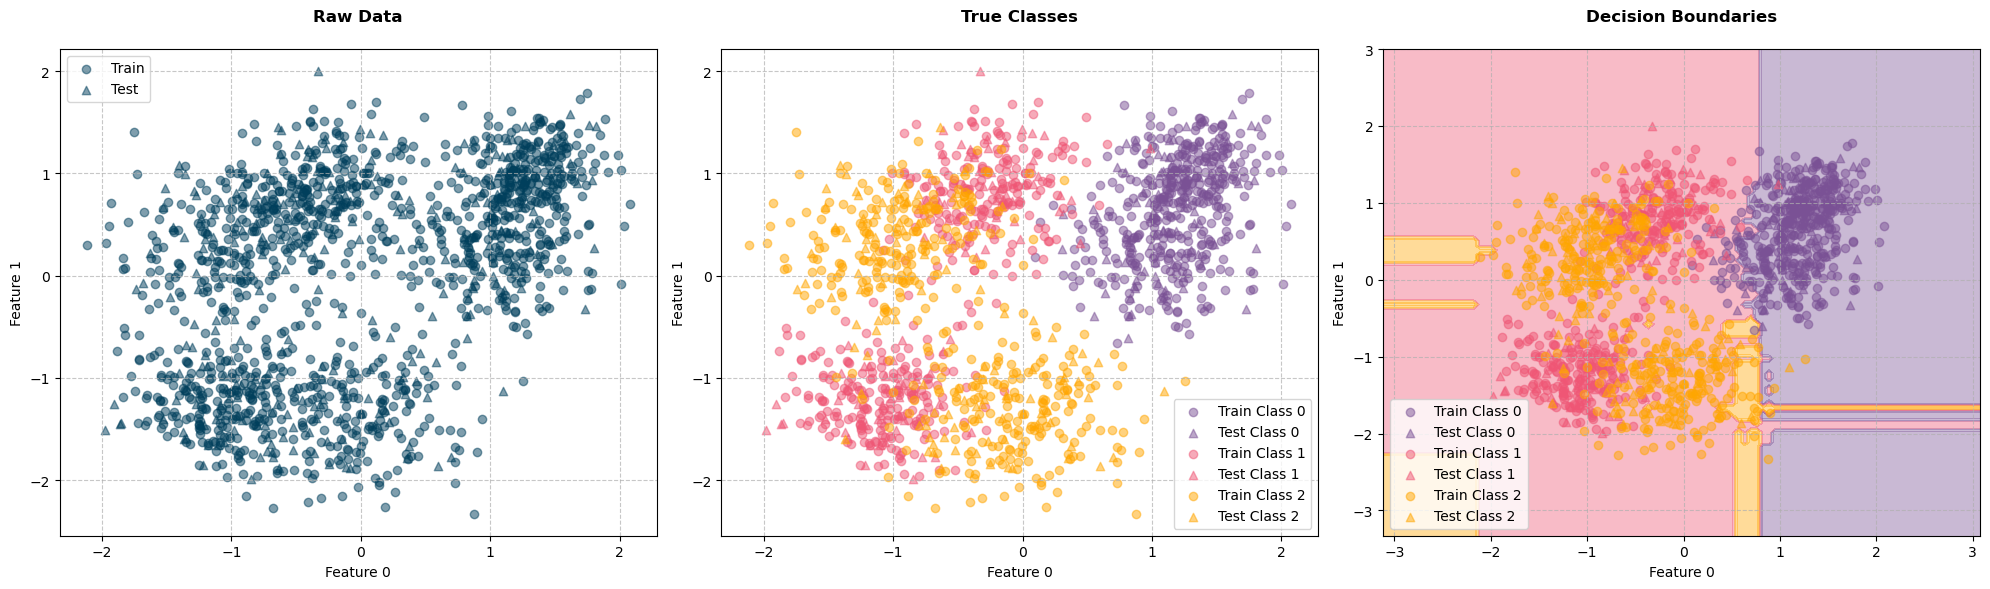

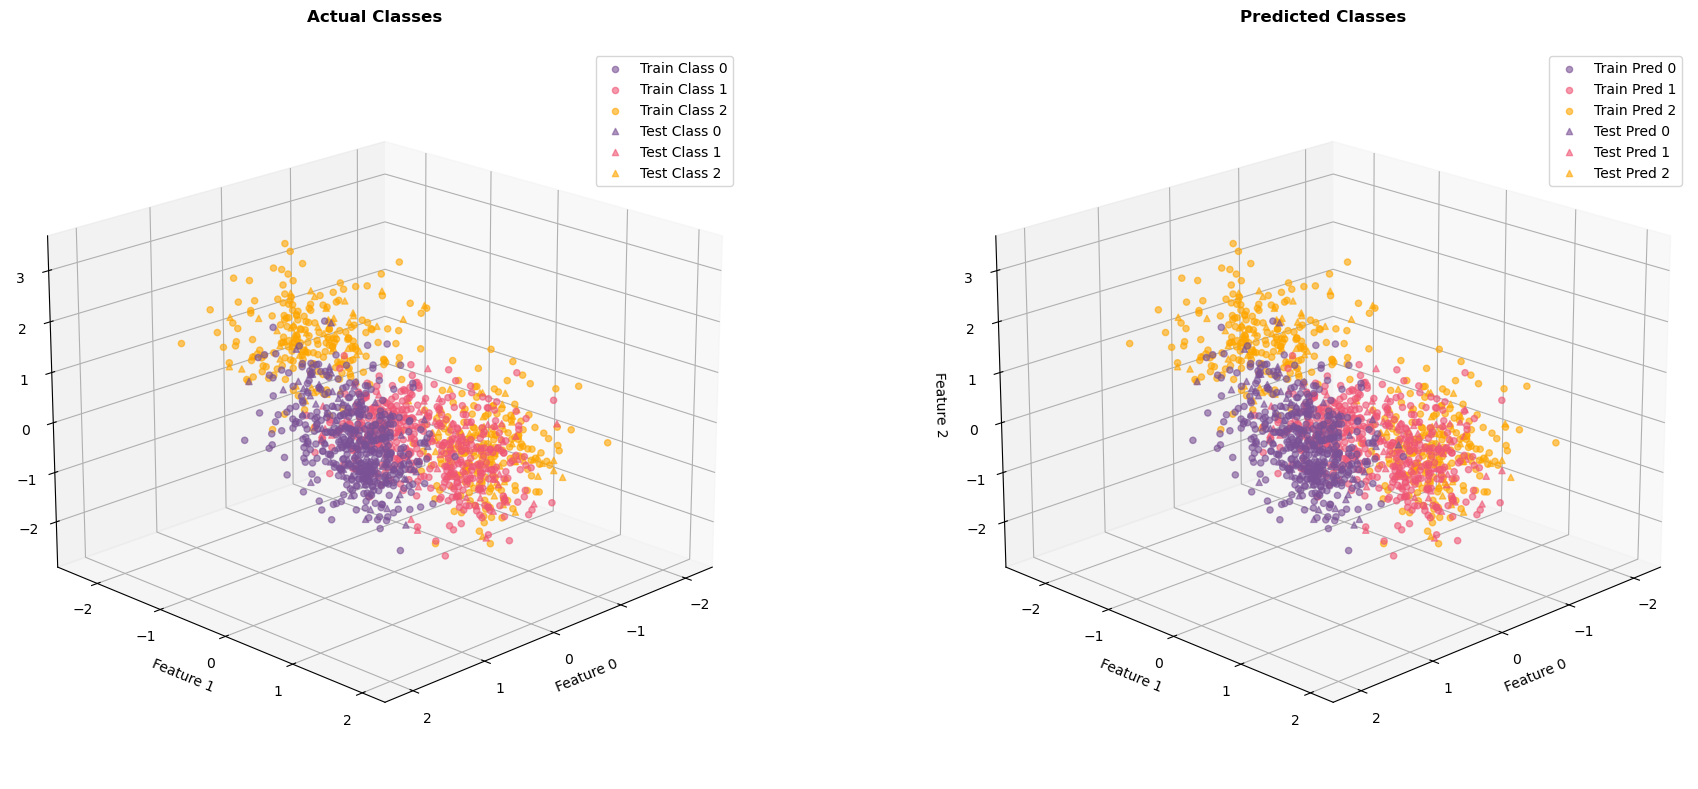

In [13]:
if __name__ == "__main__":
    X, y = generate_data(n_samples=1500, 
                        n_features=4, 
                        n_classes=3, 
                        n_clusters_per_class=2,
                        noise_level=0.3,  
                        overlap_factor=0.1)  

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_scaled, X_test_scaled, _, _ = standardize_data(X_train, X_test)

    rf = RandomForestClassifier(
        n_estimators=200,  
        max_depth=15,      
        min_samples_split=2,  
        max_features='sqrt'
    )
    rf.fit(X_train_scaled, y_train)

    y_pred = rf.predict(X_test_scaled)

    metrics = evaluate_classifier(y_test, y_pred, n_classes=3)

    print("\nClassification Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Macro-averaged Precision: {metrics['macro_precision']:.4f}")
    print(f"Macro-averaged Recall: {metrics['macro_recall']:.4f}")
    print(f"Macro-averaged F1: {metrics['macro_f1']:.4f}")
    
    print("\nPer-class Metrics:")
    for class_idx, class_metrics in metrics['per_class'].items():
        print(f"\n{class_idx}:")
        for metric_name, value in class_metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    visualize_all(X_train_scaled, X_test_scaled, y_train, y_test, 
                 model=rf, 
                 feature_pair=(0, 1), 
                 feature_triplet=(0, 1, 2))